In [8]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [9]:
from __future__ import print_function
import keras
from keras.models import Model
from art import config
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, PixelAttack
from art.estimators.classification.keras import KerasClassifier

In [10]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('gtsrb-resnet18.h5')

In [11]:
classifier = KerasClassifier(model=model, clip_values=None, use_logits=False)

In [12]:
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import transform

def preprocess(img):
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img = np.array(img)
    img = transform.resize(img, (32, 32))
    #img = exposure.equalize_adapthist(img, clip_limit=0.1)
    img = np.reshape(img,[1,32,32,3])
    return img

In [126]:
# Attack on one image
from PIL import Image
import numpy as np

image = Image.open("/home/kritika/Downloads/FYP/dataset/GTSRB/new_train/0/00000_00000_00001.png")
#image = Image.open("/home/kritika/Downloads/FYP/dataset/GTSRB/meta/1.png")
image = preprocess(image)

attacker = FastGradientMethod(estimator=classifier, eps=0.05)
x_attack = attacker.generate(x=image)

In [127]:
x_attack[0].shape

(32, 32, 3)

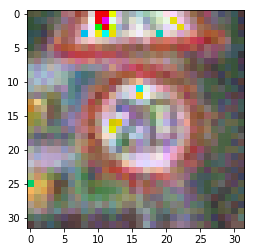

In [128]:
plt.imshow(x_attack[0])

In [60]:
attack = ProjectedGradientDescent(classifier, eps=0.05, eps_step=0.01, max_iter=40, targeted=False, 
                                  num_random_init=True)
x_attack = attack.generate(x=image)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

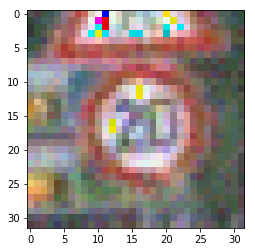

In [61]:
plt.imshow(x_attack[0])

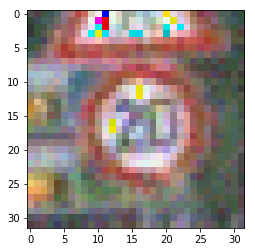

In [62]:
data = 255 * x_attack[0] # Now scale by 255
img = data.astype(np.uint8)
plt.imshow(img)
#plt.imsave("attacked_02.png",img)

In [56]:
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import transform
img = cv2.imread('attacked_02.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = transform.resize(img, (32, 32))
img = exposure.equalize_adapthist(img, clip_limit=0.1)
img = np.reshape(img,[1,32,32,3])
classes = model.predict(img)
r = np.argmax(classes[0],axis=0)
print(r)
print(classes)

40
[[2.22031542e-11 4.39434666e-09 3.67863663e-06 7.79482090e-10
  1.33717067e-05 6.29736130e-09 4.24638547e-10 1.77483408e-12
  4.46440751e-09 9.22746235e-09 1.35939882e-08 2.27281249e-11
  3.55785484e-10 1.43165335e-06 3.55432950e-09 1.81395298e-11
  1.12892815e-08 4.28854813e-10 9.33390865e-11 8.78048809e-07
  1.47222790e-09 3.33109584e-09 3.70749334e-11 8.22431350e-04
  2.84231926e-11 2.07531103e-09 1.20649584e-13 8.54276025e-11
  4.87457644e-12 1.11687916e-11 1.38470602e-13 1.65956712e-12
  6.15802060e-13 1.69328923e-04 2.64640016e-06 1.74173120e-08
  1.93177490e-04 1.96213132e-05 1.80058032e-05 9.61208286e-08
  9.98754978e-01 2.62380695e-07 7.94506960e-11]]


In [ ]:
#x_attack = np.clip(x_attack, -1, 1)

x_attack = exposure.equalize_adapthist(x_attack, clip_limit=0.1)
predictions = classifier.predict(x=x_attack)
r = np.argmax(predictions[0],axis=0)
print(r)
print(predictions)
plt.imshow(x_attack[0])

# Generate Adv samples for whole dataset (new_train)

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import transform
import os
data = []
labels = []
#path = "/home/kritika/Downloads/FYP/dataset/GTSRB/pre-processed_images/"
path = "/home/kritika/Downloads/FYP/dataset/GTSRB/new_train/"

for folder in range(43):
    for img in os.listdir(path+str(folder)):
        image = Image.open(path+str(folder)+"/"+img)
        if image.mode == "RGBA":
            image = image.convert("RGB")
        image = np.array(image)
        image = transform.resize(image, (32, 32))
        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(folder))

In [15]:
import sklearn.preprocessing
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(labels)+1))
labels = label_binarizer.transform(labels)

In [16]:
labels.shape

(6535, 43)

In [17]:
labels[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [3]:
data = np.array(data)
data.shape

(6535, 32, 32, 3)

In [19]:
data[0].shape

(32, 32, 3)

In [13]:
import numpy as np
import time

fgsm = FastGradientMethod(classifier, eps=0.01)
data_adv = fgsm.generate(x=data)

/home/kritika/anaconda3/envs/toit/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [21]:
save_path = "/home/kritika/Downloads/FYP/dataset/GTSRB/adv_fgsm_0_1/"

for i in range(data.shape[0]):
    fold = np.argmax(labels[i])
    if not os.path.exists(save_path + str(fold)):
        os.mkdir(save_path + str(fold))
    #data = 255 * x_attack[0] # Now scale by 255
    #img = data.astype(np.uint8)
    plt.imsave(save_path+str(fold)+"/"+str(i)+"_0_1.png", data_adv[i])

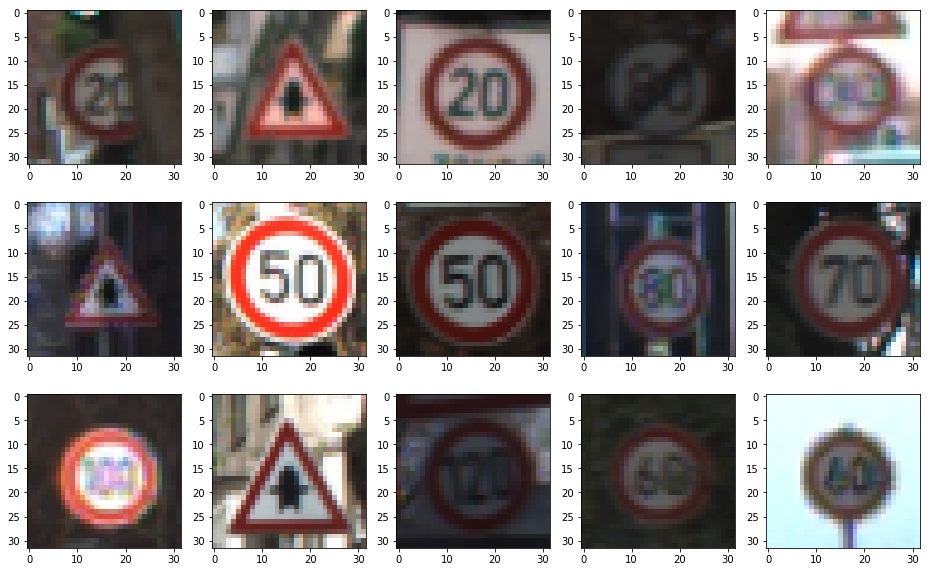

In [6]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(data[np.random.randint(3000, size=1)[0]][:,:,:])

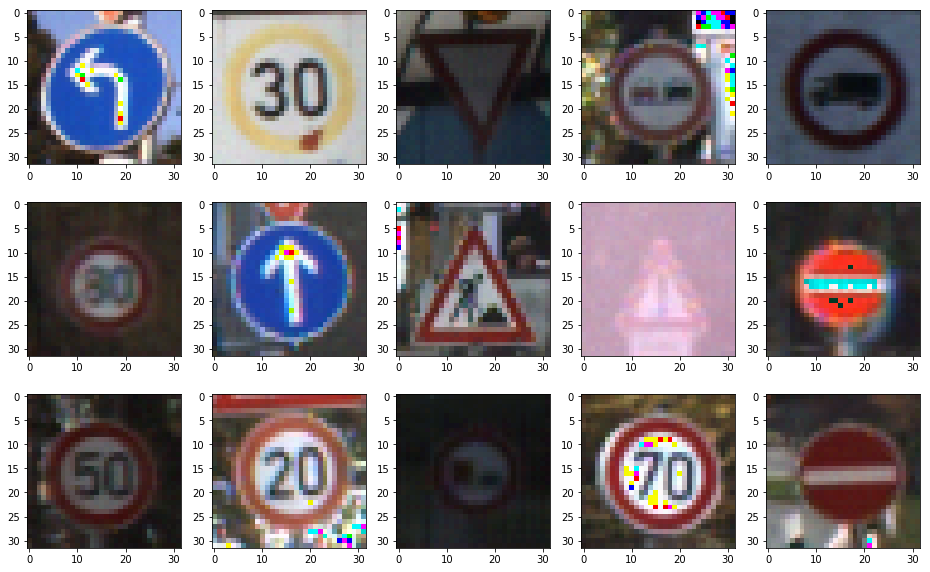

In [33]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(data_adv[np.random.randint(6000, size=1)[0]][:,:,:])

In [61]:
start = time.process_time()
predictions = classifier.predict(data_adv)
print("Time taken for single prediction: {}".format((time.process_time() - start)/12630))

Time taken for single prediction: 0.002458337284639747


In [62]:
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1)) / len(labels)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 7.390971690895181%


In [13]:
data_adv[0].shape

(32, 32, 3)

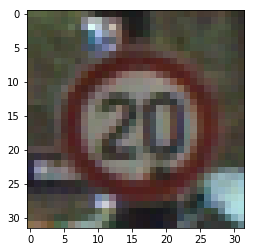

In [14]:
plt.imshow(data_adv[1])

In [44]:
# Attack on one image
from PIL import Image
import numpy as np

image = Image.open("/home/kritika/Downloads/FYP/dataset/GTSRB/new_train/0/00000_00000_00001.png")
#image = Image.open("/home/kritika/Downloads/FYP/dataset/GTSRB/meta/1.png")
image = preprocess(image)

attacker = FastGradientMethod(estimator=classifier, eps=0.05)
x_attack = attacker.generate(x=image)

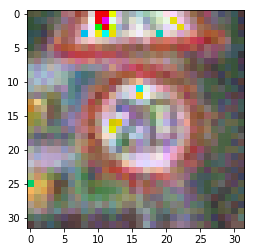

In [47]:
plt.imshow(x_attack[0])

38 13


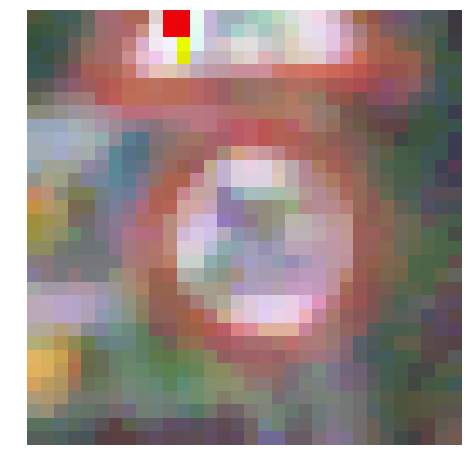

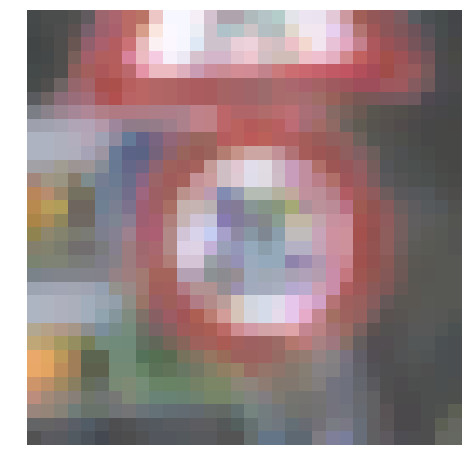

In [46]:
from art.defences.preprocessor import SpatialSmoothing
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(image)
x_art_adv_def, _ = ss(x_attack)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print(label_def, label_adv_def)
"""# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))"""

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0]); plt.axis('off'); plt.show()
plt.figure(figsize=(8,8)); plt.imshow(x_art_def[0]); plt.axis('off'); plt.show()